# CV Homework 01

## Import necessary libraries

In [ ]:
import numpy as np
import cv2
from PIL import Image
import math
import matplotlib.pyplot as plt

## Warping

In [96]:
def homo_coordinate(coordinate):
    '''Homogeneous coordinate calculation'''

    x = coordinate[0]/coordinate[2]
    y = coordinate[1]/coordinate[2]
    return x, y


def warp(image, H):
    '''warping image as per the homography matrix'''
    
    print("Warping is started.")

    image_array = np.array(image)
    row_number, column_number = int(image_array.shape[0]), int(image_array.shape[1])

    low_left_x, low_left_y = homo_coordinate(np.dot(H, [[0],[row_number-1],[1]]))
    low_right_x, low_right_y = homo_coordinate(np.dot(H, [[column_number-1],[row_number-1],[1]]))
    up_left_x, up_left_y = homo_coordinate(np.dot(H, [[0],[0],[1]]))
    up_right_x, up_right_y = homo_coordinate(np.dot(H, [[column_number-1],[0],[1]]))

    x_val = [up_left_x, up_right_x, low_right_x, low_left_x]
    y_val = [up_left_y, up_right_y, low_left_y,  low_right_y]

    offset_x = math.floor(np.min(x_val))
    offset_y = math.floor(np.min(y_val))

    max_x = math.ceil(np.max(x_val))
    max_y = math.ceil(np.max(y_val))

    size_x = max_x - offset_x
    size_y = max_y - offset_y

    H_inv = np.linalg.inv(H)

    result = np.zeros((size_y, size_x, 3))

    for x in range(size_x):
        for y in range(size_y):
            point_xy = homo_coordinate(np.dot(H_inv, [[x+offset_x], [y+offset_y], [1]]))
            point_x = int(point_xy[0][0])
            point_y = int(point_xy[1][0])

            if (point_x >= 0 and point_x < column_number and point_y >= 0 and point_y < row_number):
                result[y, x, :] = image_array[point_y, point_x, :]

    print("Warping is completed!")
    return result, offset_x, offset_y

## Finding Homography

In [97]:
def getPerspectiveTransform(src, dst):
    '''supporting function to estimate Homography'''

    assert len(src) == 4 and len(dst) == 4 #Source and destination must each have 4 points.

    # Construct the coefficient matrix A
    coeff_mat = []
    for i in range(4):
        x, y = src[i]
        u, v = dst[i]
        coeff_mat.append([-x, -y, -1, 0, 0, 0, x*u, y*u, u])
        coeff_mat.append([0, 0, 0, -x, -y, -1, x*v, y*v, v])
    coeff_mat = np.array(coeff_mat)

    _, _, V = np.linalg.svd(coeff_mat)
    H = V[-1, :].reshape(3, 3)

    return H / H[2, 2]  # Normalize by the last element to ensure H[2, 2] == 1


def perspective_transform(pts1, H):
    '''supporting function to estimate Homography'''

    pts1_reshaped = pts1.reshape(-1, 1, 2)

    # Perform perspective transformation
    transformed_pts = np.matmul(H, np.concatenate([pts1_reshaped, np.ones((pts1_reshaped.shape[0], 1, 1))], axis=2).transpose(0, 2, 1))

    # Normalize the transformed points by dividing by the last coordinate
    transformed_pts = transformed_pts[:, :2, :] / transformed_pts[:, 2:3, :]

    transformed_pts_reshaped = transformed_pts.reshape(-1, 2)

    return transformed_pts_reshaped

# estimate homography matrix using RANSAC method
def estimate_homography(pts1, pts2, threshold=4, iter=100):
    '''finding homography matrix'''

    print("Finding Homography")
    best_H = None
    final_inliers = 0
    
    for i in range(iter):
        rand_indices = np.random.choice(pts1.shape[0], 4, replace=False)
        rand_pts1 = pts1[rand_indices]
        rand_pts2 = pts2[rand_indices]
        
        H = getPerspectiveTransform(rand_pts1, rand_pts2)
        
        transformed_pts = perspective_transform(pts1, H)
        
        distances = np.linalg.norm(transformed_pts - pts2, axis=1)
        
        inliers = np.sum(distances < threshold)
        
        #best H has maximum number of inliers
        if inliers > final_inliers:
            final_inliers = inliers
            best_H = H
    print("Found homography matrix!")   
    print("Homography matrix: ", "\n", best_H) 
    
    return best_H

## Finding and matching keypoints

In [98]:
def find_keypts(img1, img2):
    '''Finding and matching SIFT keypoints'''

    print("Finding keypoints")
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()

    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)

    # Initialize FLANN matcher
    flann = cv2.FlannBasedMatcher()
    matches = flann.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
    return good_matches, kp1, kp2

In [99]:
def match_keypts(good_matches, kp1, kp2):
    '''matched keypoints in image1 an image2'''

    matched_kp1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    matched_kp2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    print("Found keypoints!")
    
    # Estimate homography using RANSAC
    H = estimate_homography(matched_kp1[:,0], matched_kp2[:,0])
    return H

In [100]:
# Load images
img1 = cv2.imread('homework01.images\image01.jpg')
img2 = cv2.imread('homework01.images\image02.jpg')
img3 = cv2.imread('homework01.images\image03.jpg')
img4 = cv2.imread('homework01.images\image04.jpg')
img5 = cv2.imread('homework01.images\image05.jpg')

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)
img5 = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)
print(img1.shape)


(4032, 3024, 3)


## Stitching and Blending

In [101]:
def blend_images(left, right, l_right_offset_x, l_right_offset_y, blend):
    '''stitching and blending images'''

    print("Blending three images is started.")

    #left = np.array(left)
    #middle = np.array(middle)

    rows_left, columns_left = int(left.shape[0]), int(left.shape[1])
    rows_right, columns_right = int(right.shape[0]), int(right.shape[1])

    x_min = min([l_right_offset_x, 0])
    x_max = max([l_right_offset_x+columns_left, columns_right])

    y_min = min([l_right_offset_y, 0])
    y_max = max([rows_left+l_right_offset_y, rows_right])

    size_x = x_max - x_min
    size_y = y_max - y_min

    blending = np.zeros((size_y, size_x, 3))

    blending[:rows_left, :columns_left, :] = left[:, :, :]

    if blend == 0: #if no blending required
        blending[-l_right_offset_y:rows_right-l_right_offset_y, -l_right_offset_x:columns_right-l_right_offset_x, :] = right[:, :, :]
    else:           #if blending required
        blending[-l_right_offset_y:rows_right-l_right_offset_y, -l_right_offset_x:columns_right-l_right_offset_x, :] = \
       np.where(np.mean(right[:2], axis=0) <
                np.mean(blending[-l_right_offset_y:rows_right-l_right_offset_y, -l_right_offset_x:columns_right-l_right_offset_x, :][:2], axis=0),
                blending[-l_right_offset_y:rows_right-l_right_offset_y, -l_right_offset_x:columns_right-l_right_offset_x, :], right)

        #blending by averaging
        #blending[-l_right_offset_y:rows_right-l_right_offset_y, -l_right_offset_x:columns_right-l_right_offset_x, :] = \
       #(right + blending[-l_right_offset_y:rows_right-l_right_offset_y, -l_right_offset_x:columns_right-l_right_offset_x, :]) / 2

    print("Blending is completed!")
    return blending

## Outputs with blend for given set of images

Finding keypoints


Found keypoints!
Finding Homography
Found homography matrix!
Homography matrix:  
 [[ 1.23475523e+00 -3.05959553e-02 -7.58758842e+02]
 [ 1.49407128e-01  1.15871027e+00 -3.87340648e+02]
 [ 6.14666547e-05  9.54303210e-06  1.00000000e+00]]
Warping is started.
Warping is completed!
Blending three images is started.
Blending is completed!


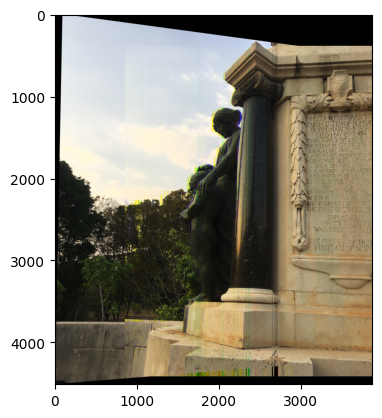

In [102]:
good_matches, kp1, kp2 = find_keypts(img1, img2)

H1 = match_keypts(good_matches, kp1, kp2)

warped_image_source1, source1_offset_x, source1_offset_y = warp(img1, H1)

blend = 1
blended_img1 = blend_images(warped_image_source1, np.array(img2), source1_offset_x, source1_offset_y, blend)
result1 = Image.fromarray(blended_img1.astype('uint8'), 'RGB')

plt.imshow(result1)
plt.show()
result1.save("result1.jpg")

In [103]:
result1 = cv2.imread("result1.jpg")
result1 = cv2.cvtColor(result1, cv2.COLOR_BGR2RGB)

In [104]:
good_matches, kp1, kp2 = find_keypts(result1, img3)

H2 = match_keypts(good_matches, kp1, kp2)

warped_image_source2, source2_offset_x, source2_offset_y = warp(result1, H2)
blended_img2 = blend_images(warped_image_source2, np.array(img3), source2_offset_x, source2_offset_y, blend)
result2 = Image.fromarray(blended_img2.astype('uint8'), 'RGB')

plt.imshow(result2)
plt.show()
result2.save("result2.jpg")

Finding keypoints


Found keypoints!
Finding Homography
Found homography matrix!
Homography matrix:  
 [[ 1.18920438e+00 -1.56218118e-02 -1.73167620e+03]
 [ 1.14716532e-01  1.15944500e+00 -8.79942060e+02]
 [ 4.39199545e-05  9.93755105e-06  1.00000000e+00]]
Warping is started.
Warping is completed!
Blending three images is started.
Blending is completed!


Finding keypoints


Found keypoints!
Finding Homography
Found homography matrix!
Homography matrix:  
 [[ 1.38029457e+00 -7.81596339e-02 -3.22436276e+03]
 [ 2.27652727e-01  1.29551236e+00 -2.05349519e+03]
 [ 7.66792116e-05  3.34820276e-06  1.00000000e+00]]
Warping is started.
Warping is completed!
Blending three images is started.
Blending is completed!


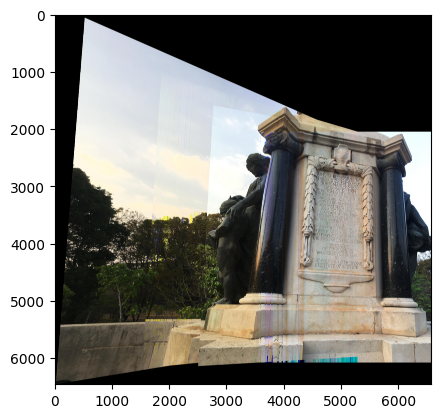

In [105]:
result2 = cv2.imread("result2.jpg")
result2 = cv2.cvtColor(result2, cv2.COLOR_BGR2RGB)

good_matches, kp1, kp2 = find_keypts(result2, img4)

H3 = match_keypts(good_matches, kp1, kp2)

warped_image_source3, source3_offset_x, source3_offset_y = warp(result2, H3)
blended_img3 = blend_images(warped_image_source3, np.array(img4), source3_offset_x, source3_offset_y, blend)

result3 = Image.fromarray(blended_img3.astype('uint8'), 'RGB')

plt.imshow(result3)
plt.show()
result3.save("result3.jpg")

In [106]:
result3 = cv2.imread("result3.jpg")
result3 = cv2.cvtColor(result3, cv2.COLOR_BGR2RGB)

good_matches, kp1, kp2 = find_keypts(result3, img5)

H4 = match_keypts(good_matches, kp1, kp2)
#H4_inv = np.linalg.inv(H4)

warped_image_source4, source4_offset_x, source4_offset_y = warp(result3, H4)
blended_img4 = blend_images(warped_image_source4, np.array(img5), source4_offset_x, source4_offset_y, blend)
result4 = Image.fromarray(blended_img4.astype('uint8'), 'RGB')

plt.imshow(result4)
plt.show()


Finding keypoints
Found keypoints!
Finding Homography
Found homography matrix!
Homography matrix:  
 [[ 1.43445662e+00 -6.31043904e-02 -5.80173776e+03]
 [ 1.88465267e-01  1.33981527e+00 -3.77930497e+03]
 [ 6.49304316e-05 -2.45334832e-06  1.00000000e+00]]
Warping is started.
Warping is completed!
Blending three images is started.
Blending is completed!


In [107]:
result4.save("result4.jpg")

## Outputs without blend for given set of images

In [108]:
good_matches, kp1, kp2 = find_keypts(img1, img2)

H1 = match_keypts(good_matches, kp1, kp2)

warped_image_source1, source1_offset_x, source1_offset_y = warp(img1, H1)

blend = 0
stitched_img1 = blend_images(warped_image_source1, np.array(img2), source1_offset_x, source1_offset_y, blend)
result1 = Image.fromarray(stitched_img1.astype('uint8'), 'RGB')

plt.imshow(result1)
plt.show()
result1.save("result1_stitched.jpg")

Finding keypoints


Found keypoints!
Finding Homography
Found homography matrix!
Homography matrix:  
 [[ 1.13799702e+00 -2.87195372e-02 -6.13534152e+02]
 [ 1.28735910e-01  1.10622430e+00 -3.32019968e+02]
 [ 4.23273395e-05  8.68624547e-06  1.00000000e+00]]
Warping is started.
Warping is completed!
Blending three images is started.
Blending is completed!


Finding keypoints
Found keypoints!
Finding Homography
Found homography matrix!
Homography matrix:  
 [[ 1.14436906e+00 -1.04425342e-02 -1.48466219e+03]
 [ 1.00937999e-01  1.13130425e+00 -7.48096857e+02]
 [ 3.57603999e-05  1.15202689e-05  1.00000000e+00]]
Warping is started.
Warping is completed!
Blending three images is started.
Blending is completed!


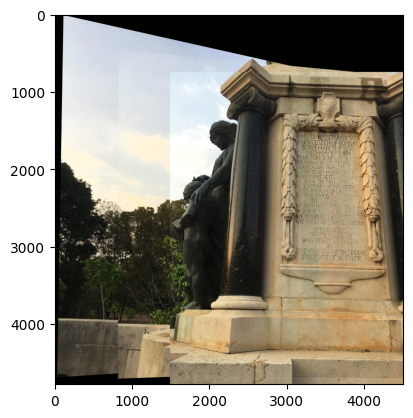

In [109]:
result1 = cv2.imread("result1_stitched.jpg")
result1 = cv2.cvtColor(result1, cv2.COLOR_BGR2RGB)

good_matches, kp1, kp2 = find_keypts(result1, img3)

H2 = match_keypts(good_matches, kp1, kp2)

warped_image_source2, source2_offset_x, source2_offset_y = warp(result1, H2)
blended_img2 = blend_images(warped_image_source2, np.array(img3), source2_offset_x, source2_offset_y, blend)
result2 = Image.fromarray(blended_img2.astype('uint8'), 'RGB')

plt.imshow(result2)
plt.show()
result2.save("result2_stitched.jpg")

In [110]:
result2 = cv2.imread("result2_stitched.jpg")
result2 = cv2.cvtColor(result2, cv2.COLOR_BGR2RGB)

good_matches, kp1, kp2 = find_keypts(result2, img4)

H3 = match_keypts(good_matches, kp1, kp2)

warped_image_source3, source3_offset_x, source3_offset_y = warp(result2, H3)
blended_img3 = blend_images(warped_image_source3, np.array(img4), source3_offset_x, source3_offset_y, blend)

result3 = Image.fromarray(blended_img3.astype('uint8'), 'RGB')

plt.imshow(result3)
plt.show()
result3.save("result3_stitched.jpg")

Finding keypoints
Found keypoints!
Finding Homography
Found homography matrix!
Homography matrix:  
 [[ 1.35900010e+00 -7.65141888e-02 -2.85405186e+03]
 [ 2.25773340e-01  1.27083975e+00 -1.79961422e+03]
 [ 7.56634666e-05  3.30921645e-06  1.00000000e+00]]
Warping is started.
Warping is completed!
Blending three images is started.
Blending is completed!


In [112]:
result3 = cv2.imread("result3_stitched.jpg")
result3 = cv2.cvtColor(result3, cv2.COLOR_BGR2RGB)

good_matches, kp1, kp2 = find_keypts(result3, img5)

H4 = match_keypts(good_matches, kp1, kp2)
#H4_inv = np.linalg.inv(H4)

warped_image_source4, source4_offset_x, source4_offset_y = warp(result3, H4)
blended_img4 = blend_images(warped_image_source4, np.array(img5), source4_offset_x, source4_offset_y, blend)
result4 = Image.fromarray(blended_img4.astype('uint8'), 'RGB')

plt.imshow(result4)
plt.show()


Finding keypoints
Found keypoints!
Finding Homography
Found homography matrix!
Homography matrix:  
 [[ 1.45152409e+00 -6.31450679e-02 -5.32379723e+03]
 [ 2.03184416e-01  1.35787723e+00 -3.47214624e+03]
 [ 7.21190012e-05 -7.19325416e-07  1.00000000e+00]]
Warping is started.
Warping is completed!
Blending three images is started.
Blending is completed!


In [113]:
result4.save("result4_stitched.jpg")

## My own input images

In [114]:
img1 = cv2.imread('homework01.images\img1_1..png')
img2 = cv2.imread('homework01.images\img1_2.png')
img3 = cv2.imread('homework01.images\img2_1.png')
img4 = cv2.imread('homework01.images\img3_1.png')
img5 = cv2.imread('homework01.images\img4_1.png')

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)
img5 = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)
print(img1.shape)

(1296, 1011, 3)


## Outputs without blend for my own set of images

Finding keypoints


Found keypoints!
Finding Homography
Found homography matrix!
Homography matrix:  
 [[ 1.00000928e+00  1.65065411e-06 -1.88004036e+02]
 [ 4.13592048e-06  1.00001264e+00 -7.33901739e-03]
 [ 4.39342518e-09  5.14126086e-09  1.00000000e+00]]
Warping is started.
Warping is completed!
Blending three images is started.
Blending is completed!


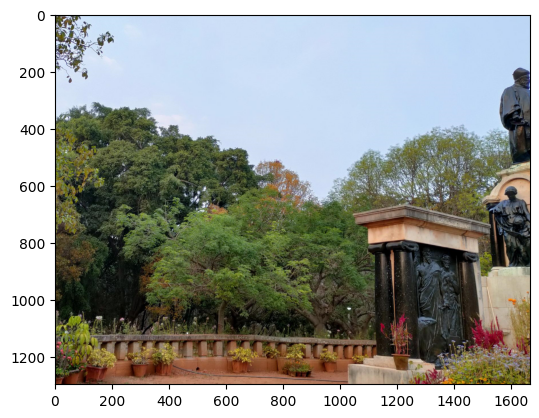

In [115]:
good_matches, kp1, kp2 = find_keypts(img1, img2)

H1 = match_keypts(good_matches, kp1, kp2)

warped_image_source1, source1_offset_x, source1_offset_y = warp(img1, H1)

blend = 1
blended_img1 = blend_images(warped_image_source1, np.array(img2), source1_offset_x, source1_offset_y, blend)
result1 = Image.fromarray(blended_img1.astype('uint8'), 'RGB')

plt.imshow(result1)
plt.show()
result1.save("result1_myimgs.jpg")

In [116]:
result1 = cv2.imread("result1_myimgs.jpg")
result1 = cv2.cvtColor(result1, cv2.COLOR_BGR2RGB)


In [117]:
good_matches, kp1, kp2 = find_keypts(result1, img3)

H2 = match_keypts(good_matches, kp1, kp2)

warped_image_source2, source2_offset_x, source2_offset_y = warp(result1, H2)
blended_img2 = blend_images(warped_image_source2, np.array(img3), source2_offset_x, source2_offset_y, blend)
result2 = Image.fromarray(blended_img2.astype('uint8'), 'RGB')

plt.imshow(result2)
plt.show()
result2.save("result2_myimgs.jpg")

Finding keypoints


Found keypoints!
Finding Homography
Found homography matrix!
Homography matrix:  
 [[ 1.07386641e+00 -5.63092948e-02 -9.86746328e+02]
 [ 1.59064205e-01  1.10722871e+00 -1.41426158e+02]
 [ 1.68860706e-04 -5.49630962e-06  1.00000000e+00]]
Warping is started.
Warping is completed!
Blending three images is started.
Blending is completed!


Finding keypoints


Found keypoints!
Finding Homography
Found homography matrix!
Homography matrix:  
 [[ 1.17054661e+00 -8.17046383e-02 -1.64308976e+03]
 [ 1.74048764e-01  1.18620657e+00 -3.76253764e+02]
 [ 1.69379510e-04 -2.10503465e-05  1.00000000e+00]]
Warping is started.
Warping is completed!
Blending three images is started.
Blending is completed!


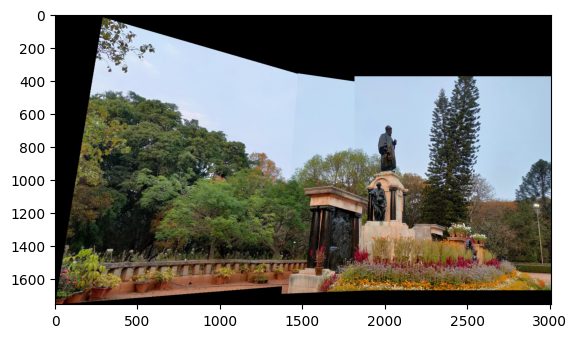

In [118]:
result2 = cv2.imread("result2_myimgs.jpg")
result2 = cv2.cvtColor(result2, cv2.COLOR_BGR2RGB)


good_matches, kp1, kp2 = find_keypts(result2, img4)

H3 = match_keypts(good_matches, kp1, kp2)

warped_image_source3, source3_offset_x, source3_offset_y = warp(result2, H3)
blended_img3 = blend_images(warped_image_source3, np.array(img4), source3_offset_x, source3_offset_y, blend)

result3 = Image.fromarray(blended_img3.astype('uint8'), 'RGB')

plt.imshow(result3)
plt.show()
result3.save("result3_myimgs.jpg")

Finding keypoints
Found keypoints!
Finding Homography
Found homography matrix!
Homography matrix:  
 [[ 1.34356363e+00 -6.84767885e-02 -2.64474636e+03]
 [ 1.60839231e-01  1.33261842e+00 -8.41509514e+02]
 [ 1.59126988e-04  7.31694115e-07  1.00000000e+00]]
Warping is started.
Warping is completed!
Blending three images is started.
Blending is completed!


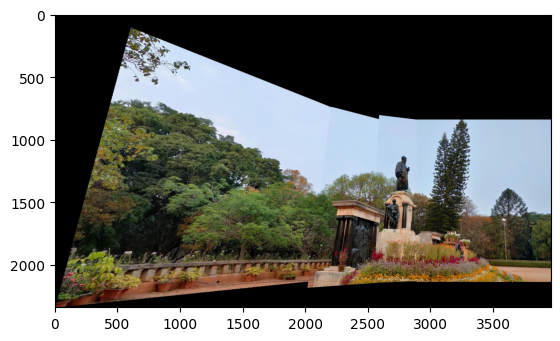

In [119]:
result3 = cv2.imread("result3_myimgs.jpg")
result3 = cv2.cvtColor(result3, cv2.COLOR_BGR2RGB)

good_matches, kp1, kp2 = find_keypts(result3, img5)

H4 = match_keypts(good_matches, kp1, kp2)
#H4_inv = np.linalg.inv(H4)

warped_image_source4, source4_offset_x, source4_offset_y = warp(result3, H4)
blended_img4 = blend_images(warped_image_source4, np.array(img5), source4_offset_x, source4_offset_y, blend)
result4 = Image.fromarray(blended_img4.astype('uint8'), 'RGB')

plt.imshow(result4)
plt.show()


In [120]:
result4.save("result4_myimgs.jpg")

## Outputs without blend for my own set of images

Finding keypoints


Found keypoints!
Finding Homography
Found homography matrix!
Homography matrix:  
 [[ 1.00000018e+00 -1.46880996e-07 -1.87999949e+02]
 [ 2.70039723e-07  9.99999885e-01 -3.54692609e-05]
 [ 3.50133814e-10 -2.09777971e-10  1.00000000e+00]]
Warping is started.
Warping is completed!
Blending three images is started.
Blending is completed!


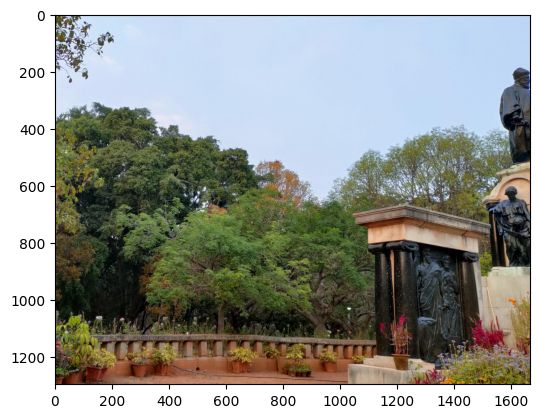

In [121]:
good_matches, kp1, kp2 = find_keypts(img1, img2)

H1 = match_keypts(good_matches, kp1, kp2)

warped_image_source1, source1_offset_x, source1_offset_y = warp(img1, H1)

blend = 0
blended_img1 = blend_images(warped_image_source1, np.array(img2), source1_offset_x, source1_offset_y, blend)
result1 = Image.fromarray(blended_img1.astype('uint8'), 'RGB')

plt.imshow(result1)
plt.show()
result1.save("result1_myimgs_stitched.jpg")

Finding keypoints


Found keypoints!
Finding Homography
Found homography matrix!
Homography matrix:  
 [[ 1.09686735e+00 -5.49572679e-02 -1.01030066e+03]
 [ 1.69642809e-01  1.13542439e+00 -1.61602167e+02]
 [ 1.80685205e-04  2.06214179e-06  1.00000000e+00]]
Warping is started.
Warping is completed!
Blending three images is started.
Blending is completed!


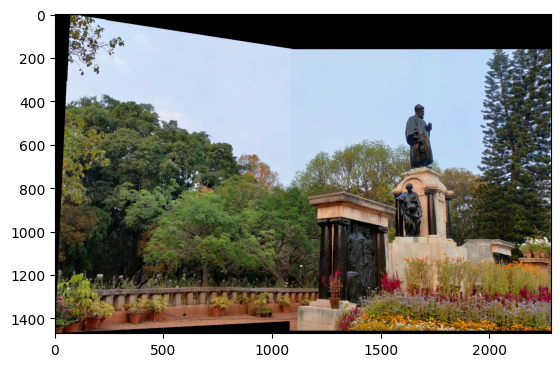

In [122]:
result1 = cv2.imread("result1_myimgs_stitched.jpg")
result1 = cv2.cvtColor(result1, cv2.COLOR_BGR2RGB)

good_matches, kp1, kp2 = find_keypts(result1, img3)

H2 = match_keypts(good_matches, kp1, kp2)

warped_image_source2, source2_offset_x, source2_offset_y = warp(result1, H2)
blended_img2 = blend_images(warped_image_source2, np.array(img3), source2_offset_x, source2_offset_y, blend)
result2 = Image.fromarray(blended_img2.astype('uint8'), 'RGB')

plt.imshow(result2)
plt.show()
result2.save("result2_myimgs_stitched.jpg")

Finding keypoints


Found keypoints!
Finding Homography
Found homography matrix!
Homography matrix:  
 [[ 1.16839107e+00 -7.68960553e-02 -1.65667276e+03]
 [ 1.70898470e-01  1.18853971e+00 -3.99838142e+02]
 [ 1.64434525e-04 -1.51135385e-05  1.00000000e+00]]
Warping is started.
Warping is completed!
Blending three images is started.
Blending is completed!


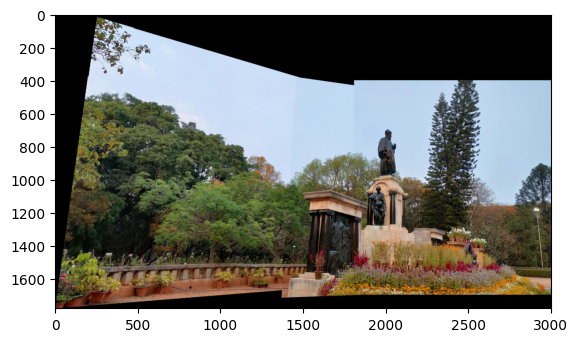

In [123]:
result2 = cv2.imread("result2_myimgs_stitched.jpg")
result2 = cv2.cvtColor(result2, cv2.COLOR_BGR2RGB)


good_matches, kp1, kp2 = find_keypts(result2, img4)

H3 = match_keypts(good_matches, kp1, kp2)

warped_image_source3, source3_offset_x, source3_offset_y = warp(result2, H3)
blended_img3 = blend_images(warped_image_source3, np.array(img4), source3_offset_x, source3_offset_y, blend)

result3 = Image.fromarray(blended_img3.astype('uint8'), 'RGB')

plt.imshow(result3)
plt.show()
result3.save("result3_myimgs_stitched.jpg")

Finding keypoints


Found keypoints!
Finding Homography
Found homography matrix!
Homography matrix:  
 [[ 1.33963406e+00 -7.14769142e-02 -2.62366755e+03]
 [ 1.67085455e-01  1.31410974e+00 -8.71774989e+02]
 [ 1.64507535e-04 -1.63992524e-05  1.00000000e+00]]
Warping is started.
Warping is completed!
Blending three images is started.
Blending is completed!


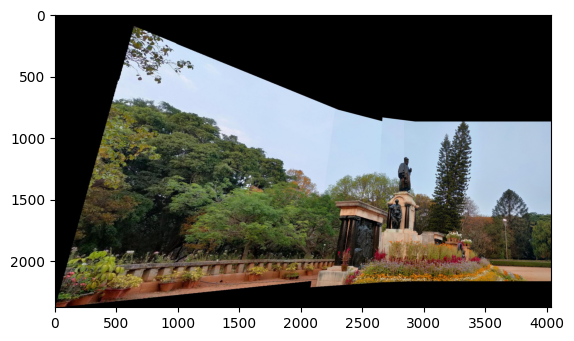

In [124]:
result3 = cv2.imread("result3_myimgs_stitched.jpg")
result3 = cv2.cvtColor(result3, cv2.COLOR_BGR2RGB)

good_matches, kp1, kp2 = find_keypts(result3, img5)

H4 = match_keypts(good_matches, kp1, kp2)
#H4_inv = np.linalg.inv(H4)

warped_image_source4, source4_offset_x, source4_offset_y = warp(result3, H4)
blended_img4 = blend_images(warped_image_source4, np.array(img5), source4_offset_x, source4_offset_y, blend)
result4 = Image.fromarray(blended_img4.astype('uint8'), 'RGB')

plt.imshow(result4)
plt.show()


In [125]:
result4.save("result4_myimgs_stitched.jpg")

*******************************************

### ThankYou!